In [188]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import time
from us import states
import gmaps
from scipy.stats import linregress
import random 
#import scipy.stats as stats

# gmaps API Keys
#from config import (census_key, gkey)

# Configure gmaps
#gmaps.configure(api_key=gkey)

In [189]:
#testing 
#!pwd

In [190]:
#load data
csv_path = "Resources/NutritionPhysicalActivityObesity.csv"
nutrition_data = pd.read_csv(csv_path)
age_groups = nutrition_data.groupby('Age(years)')
year_groups = nutrition_data.groupby('YearEnd')

# Create a dataframe counting the number of data points for each age 
age_groups_count = pd.DataFrame(age_groups['Age(years)'].count())
year_groups_count = pd.DataFrame(year_groups['YearEnd'].count())

# View the groupby dataframe 
age_groups_count
nutrition_data.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,...,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2012,2012,WY,Wyoming,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"43.235541343, -108.109830353",OWS,OWS1,Q037,VALUE,56,Race/Ethnicity,American Indian/Alaska Native,RACE,RACENAA
1,2012,2012,DC,District of Columbia,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"38.890371385, -77.031961127",OWS,OWS1,Q036,VALUE,11,Education,Less than high school,EDU,EDUHS
2,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"32.840571122, -86.631860762",OWS,OWS1,Q036,VALUE,1,Age (years),25 - 34,AGEYR,AGEYR2534
3,2013,2013,US,National,Behavioral Risk Factor Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,NaN,Value,...,NaN,PA,PA1,Q047,VALUE,59,Gender,Female,GEN,FEMALE
4,2011,2011,US,National,Behavioral Risk Factor Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,NaN,Value,...,NaN,PA,PA1,Q047,VALUE,59,Age (years),18 - 24,AGEYR,AGEYR1824


In [191]:
# drop unesscary columns and fix labels
nutrition_data = nutrition_data.drop(columns=['Data_Value_Unit',
                                              'StratificationCategory1',
                                              'YearStart',
                                              'ClassID',
                                              'TopicID',
                                              'Income',
                                              'Data_Value_Type'
                                             ])
nutrition_data[['Lat','Long']] = nutrition_data.GeoLocation.str.split(",",expand=True,)

renamecols_df = nutrition_data.rename(columns={"LocationAbbr":"StateAbbr",
                                                "LocationDesc":"State",
                                                "Age(years)":"Age",
                                                "YearEnd":"Year"})

#renamecols is df before narrowing age demographic

In [192]:
#trim age column to include only desired age demographic

renamecols_df["Year"] = renamecols_df.Year.astype(str)

agedem_df = renamecols_df.loc[(renamecols_df["Age"] == "18 - 24")
                               |(renamecols_df["Age"] == "25 - 34")
                               |(renamecols_df["Age"] == "35 - 44")
                               |(renamecols_df["Age"] == "45 - 54")
                             ,:]
#dem_df trims years to include only five years of data 2014-2018
dem_df = agedem_df.loc[(agedem_df["Year"] == "2014")
                               |(agedem_df["Year"] == "2015")
                               |(agedem_df["Year"] == "2016")
                               |(agedem_df["Year"] == "2017")
                               |(agedem_df["Year"] == "2018")
                              ,:]
#define dataframe for obesity rates for gen x and gen y
GenX_Data = agedem_df[(agedem_df["Age"] == "35 - 44") | 
                        (agedem_df["Age"] == "45 - 54")]
GenM_Data = agedem_df[(agedem_df["Age"] == "18 - 24") | 
                        (agedem_df["Age"] == "25 - 34")]

In [193]:
#narrow dataframe for bargraph that compares obesity rate by age group from 2014-2018
obesity_data_df = dem_df.drop(columns=['Data_Value_Alt',
                                    'Total',
                                    'Education',
                                    'Gender',
                                    'Race/Ethnicity',
                                    'Topic',
                                    'Stratification1'
                                             ])

weight_q_group = obesity_data_df.loc[(dem_df["QuestionID"] == "Q036")                         
                              ,:]

#bin age data to gen x and gen y
# Create the bins in which gen x and gen y will be held   
bins = [['18 - 24','25 - 34'],['35 - 44','45-54']]

# Create the names for the five bins
group_names = ["Gen Y", "Gen X"]

b = (pd.DataFrame({'Gen': group_names, 'Age': bins})
        .explode('Age')
        .reset_index(drop=True))

obesity_data_df = weight_q_group.merge(b, on = 'Age', how='left')

s = pd.Series(obesity_data_df['Data_Value'])
pd.to_numeric(s)
#obesity_data_df.head()

0       29.7
1       33.2
2       37.9
3       12.7
4       19.9
        ... 
1087    25.4
1088    31.7
1089    28.0
1090    33.7
1091    39.3
Name: Data_Value, Length: 1092, dtype: float64

In [194]:
subjecttest = ['Data_Value']
datasettest = obesity_data_df.groupby(['Year','Age'])[subjecttest].mean()
datasettest

Data_Value
Year Age                
2014 18 - 24   16.359259
     25 - 34   28.029630
     35 - 44   33.064815
     45 - 54   33.922222
2015 18 - 24   17.457407
     25 - 34   27.377778
     35 - 44   32.916667
     45 - 54   34.531481
2016 18 - 24   17.485455
     25 - 34   27.992727
     35 - 44   33.865455
     45 - 54   35.521818
2017 18 - 24   17.392593
     25 - 34   29.559259
     35 - 44   34.038889
     45 - 54   36.640741
2018 18 - 24   18.594444
     25 - 34   30.350000
     35 - 44   35.077778
     45 - 54   37.701852

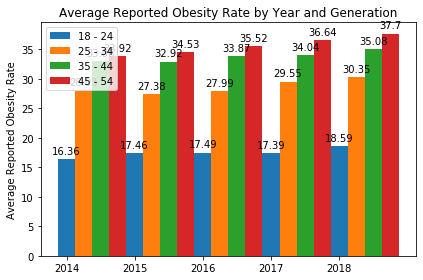

In [195]:
hhlabels =['Gen Y', 'Gen X']
labels = ['2014', '2015', '2016', '2017', '2018']
age1_means = [16.36, 17.46, 17.49, 17.39, 18.59]
age2_means = [28.03, 27.38, 27.99, 29.55, 30.35]
age3_means = [33.06, 32.92, 33.87, 34.04, 35.08]
age4_means = [33.92, 34.53, 35.52, 36.64, 37.70]

x = np.arange(len(labels))  # the label locations
hhx = np.arange(len(hhlabels))  # the high hierarchy label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x + 0.00, age1_means, width, label='18 - 24')
rects2 = ax.bar(x + 0.25, age2_means, width, label='25 - 34')
rects3 = ax.bar(x + 0.50, age3_means, width, label='35 - 44')
rects4 = ax.bar(x + 0.75, age4_means, width, label='45 - 54')

ax.set_ylabel('Average Reported Obesity Rate')
ax.set_title('Average Reported Obesity Rate by Year and Generation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

In [196]:
#define data frame for bargraph comparing reported obesity rates by year and generation
subject = ['Data_Value']
dataset = obesity_data_df.groupby(['Year','Gen'])[subject].mean()
#dataset

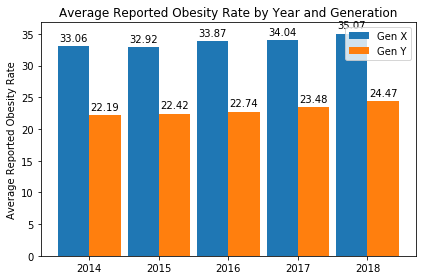

In [197]:
#Bar graph comparing Gen X and Gen Y obesity rate over time
labels = ['2014', '2015', '2016', '2017', '2018']
Genx_means = [33.06, 32.92, 33.87, 34.04, 35.07]
GenY_means = [22.19, 22.42, 22.74, 23.48, 24.47]
#formatting
x = np.arange(len(labels))  
width = 0.45

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Genx_means, width, label='Gen X')
rects2 = ax.bar(x + width/2, GenY_means, width, label='Gen Y')

# labels and markers
ax.set_ylabel('Average Reported Obesity Rate')
ax.set_title('Average Reported Obesity Rate by Year and Generation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#for loop for each rect in plt
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Year                          220
StateAbbr                     220
State                         220
Datasource                    220
Class                         220
Topic                         220
Question                      220
Data_Value                    216
Data_Value_Alt                216
Data_Value_Footnote_Symbol      4
Data_Value_Footnote             4
Low_Confidence_Limit          216
High_Confidence_Limit         216
Sample_Size                   216
Total                           0
Age                           220
Education                       0
Gender                          0
Race/Ethnicity                  0
GeoLocation                   216
QuestionID                    220
DataValueTypeID               220
LocationID                    220
Stratification1               220
StratificationCategoryId1     220
StratificationID1             220
Lat                           216
Long                          216
dtype: int64

In [256]:
GenM_Weight_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]
GenX_Weight_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]

In [257]:
GenX_activity_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
GenM_activity_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]

In [258]:
GenM_nutrition_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily")|(GenM_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily")]
GenX_nutrition_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily")|(GenX_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily")]

In [259]:
#GenX_Weight_df.dropna(subset=['Data_Value'])
GenX_sample_list = GenX_Weight_df["Data_Value"].tolist(
GenX_WeightSample = random.sample(GenX_sample_list, (204))

    
#GenM_Weight_df.dropna(subset=['Data_Value'])
GenM_sample_list = GenM_Weight_df["Data_Value"].tolist()
GenM_WeightSample = random.sample(GenM_sample_list, (204))

SyntaxError: invalid syntax (<ipython-input-259-d390d82f2a15>, line 6)

In [244]:
#GenX_activity_Samplelist = GenX_activity_df["Data_Value"].tolist()
#GenX_ActivitySample = random.sample(GenX_activity_Samplelist, (216))

#GenM_activity_Samplelist = GenM_activity_df["Data_Value"].tolist()
#GenM_ActivitySample = random.sample(GenM_activity_Samplelist, (216))

#GenX_nutrition_Samplelist = GenX_nutrition_df["Data_Value"].tolist()
#GenX_NutritionSample = random.sample(GenX_nutrition_Samplelist, (216))

#GenM_nutrition_Samplelist = GenX_nutrition_df["Data_Value"].tolist()
#GenM_NutritionSample = random.sample(GenM_activity_Samplelist, (216))

The correlation between both factors is -0.08


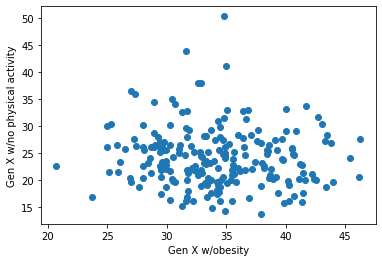

In [213]:
# The next example will compute the Pearson correlation coefficient between "GenX_Weight" and "GenX_Activity"
GenX_Weight = GenX_Weight_df.iloc[:,7]
GenX_Activity = GenX_activity_df.iloc[:,7]
correlation = sts.pearsonr(GenX_Weight,GenX_Activity)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenX_Weight,GenX_Activity)
plt.xlabel('Gen X w/obesity')
plt.ylabel('Gen X w/no physical activity')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

In [248]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenX_Weightsample = GenX_WeightSample
GenX_Nutrition = GenX_nutrition_df.iloc[:,7]
correlation = sts.pearsonr(GenX_Weightsample,GenX_Nutrition)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenX_WeightSample,GenX_Nutrition)
plt.xlabel('Gen X w/obesity')
plt.ylabel('Gen X w/no vegetable or fruit consumption')
print(f"The correlation between both factors is {round(correlation[0],2)}")

plt.show()

ValueError: array must not contain infs or NaNs

In [253]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenM_WeightSample = GenM_WeightSample
GenM_Nutrition = GenM_nutrition_df.iloc[:,7]
correlation = sts.pearsonr(GenM_WeightSample,GenM_Nutrition)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenM_WeightSample,GenM_Nutrition)
plt.xlabel('Gen M w/obesity')
plt.ylabel('Gen M w/no vegetable or fruit consumption')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

ValueError: x and y must have the same length.

In [117]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenM_Weight = GenM_Weight_df.iloc[:,7]
GenM_Activity = GenM_activity_df.iloc[:,7]
correlation = sts.pearsonr(GenM_Weight,GenM_Activity)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenM_Weight,GenM_Activity)
plt.xlabel('Gen M w/obesity')
plt.ylabel('Gen M w/no physical activity')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

ValueError: array must not contain infs or NaNs

In [254]:

# Print out the r-squared value along with the plot.
x_values = GenM_Weight
y_values = GenM_Activity
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('GenM_Weight')
plt.ylabel('GenM_Activity')
print(f"The r-squared is: {rvalue**2}")
plt.show()

C:\Users\Taylor\anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Taylor\anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Taylor\anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [599]:
Top10 = GenX_Weight_df.sort_values('Data_Value', ascending = False).head(10)
Top10

,Year,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,High_Confidence_Limit,...,Age,Education,Gender,Race/Ethnicity,GeoLocation,QuestionID,LocationID,Stratification1,Lat,Long
13759,2018,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,48.2,48.2,44.0,52.3,...,45 - 54,NaN,NaN,NaN,"(38.66551020200046, -80.71264013499967)",Q036,54,45 - 54,(38.66551020200046,-80.71264013499967)
3859,2016,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,47.5,47.5,42.7,52.5,...,35 - 44,NaN,NaN,NaN,"(32.745510099, -89.538030825)",Q036,28,35 - 44,(32.745510099,-89.538030825)
27926,2017,AL,Alabama,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,47.1,47.1,43.2,51.1,...,45 - 54,NaN,NaN,NaN,"(32.840571122, -86.631860762)",Q036,1,45 - 54,(32.840571122,-86.631860762)
17745,2017,LA,Louisiana,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.8,46.8,42.2,51.4,...,45 - 54,NaN,NaN,NaN,"(31.312660644, -92.445680071)",Q036,22,45 - 54,(31.312660644,-92.445680071)
31971,2017,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.4,46.4,42.6,50.2,...,45 - 54,NaN,NaN,NaN,"(38.665510202, -80.712640135)",Q036,54,45 - 54,(38.665510202,-80.712640135)
2828,2016,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.3,46.3,43.0,49.6,...,45 - 54,NaN,NaN,NaN,"(38.665510202, -80.712640135)",Q036,54,45 - 54,(38.665510202,-80.712640135)
8276,2018,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.3,46.3,42.4,50.4,...,45 - 54,NaN,NaN,NaN,"(32.745510099000455, -89.53803082499968)",Q036,28,45 - 54,(32.745510099000455,-89.53803082499968)
16213,2013,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.2,46.2,42.4,50.0,...,45 - 54,NaN,NaN,NaN,"(32.745510099, -89.538030825)",Q036,28,45 - 54,(32.745510099,-89.538030825)
12356,2018,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.2,46.2,41.5,51.1,...,35 - 44,NaN,NaN,NaN,"(38.66551020200046, -80.71264013499967)",Q036,54,35 - 44,(38.66551020200046,-80.71264013499967)
9952,2018,LA,Louisiana,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,45.8,45.8,41.6,50.1,...,45 - 54,NaN,NaN,NaN,"(31.31266064400046, -92.44568007099969)",Q036,22,45 - 54,(31.31266064400046,-92.44568007099969)


In [600]:
# Store 'Lat' and 'Lng' into  locations 
locations = Top10[["Lat", "Long"]].astype(float)


# Convert Obesity Rate to float and store
obesity_rate = Top10["Data_Value"].astype(float)

ValueError: could not convert string to float: '(38.66551020200046'

In [ ]:
# Create a GenX Heatmap layer
fig = gmaps.figure()

GenX_heat_layer = gmaps.heatmap_layer(locations, weights=obesity_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(GenX_heat_layer)

fig

In [ ]:
Top10_GenM = GenM_Weight_df.sort_values('Data_Value', ascending = False).head(10)

In [ ]:
# Convert activity rate to list
GenM_Obesity_rate = Top10_GenM["Data_Value"].tolist()

In [ ]:
# Create a GenM Heatmap layer
fig = gmaps.figure()

GenM_heat_layer = gmaps.heatmap_layer(locations, weights=obesity_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(GenM_heat_layer)

fig

In [ ]:
fig = gmaps.figure()

fig.add_layer(GenX_heat_layer)
fig.add_layer(GenM_heat_layer)

fig

In [ ]:
def gendata(loc=0):
    GenX = GenX_Weight_df["Data_Value"]
    GenM = GenM_Weight_df["Data_Value"]

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(GenX)), GenX, label="GenX")
    plt.scatter(range(len(GenM)), GenM, label="GenM")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(GenX, 20, density=True, alpha=0.7, label="GenX")
    plt.hist(GenM, 20, density=True, alpha=0.7, label="GenM")
    plt.axvline(GenX.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(GenM.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return GenX, GenM

In [59]:
#Making Acitivity and Nutrition Dataframes for Line Graphs
#No Activity
ActivityGenM_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
ActivityGenX_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
#Fruits and Veggies
NutritionGenM_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily") | (GenM_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily")]
NutritionGenX_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily") | (GenM_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily")]
#Obesity
ObesityGenM_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]
ObesityGenX_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]

#Achieve Means by Years to plot using groupby
ActivityYearsGenM_df =  ActivityGenM_df.groupby("Year")["Data_Value"].mean()
ActivityYearsGenX_df =  ActivityGenX_df.groupby("Year")["Data_Value"].mean()
NutritionYearsGenM_df = NutritionGenM_df.groupby("Year")["Data_Value"].mean()
NutritionYearsGenX_df = NutritionGenX_df.groupby("Year")["Data_Value"].mean()
ObesityYearsGenM_df =  ObesityGenM_df.groupby("Year")["Data_Value"].mean()
ObesityYearsGenX_df =  ObesityGenX_df.groupby("Year")["Data_Value"].mean()
ObesityYearsGenM_df.head()

C:\Users\Taylor\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Year
2011    20.798077
2012    20.991346
2013    21.450943
2014    22.194444
2015    22.417593
Name: Data_Value, dtype: float64

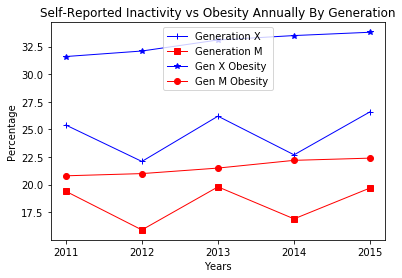

In [60]:
#ACTIVITY LINE GRAPHS -Dar
# Set x axis to numerical value for month
x_axis = "2011","2012","2013","2014","2015"



# Avearge GenX not exercising each year
activityGenX = [25.4, 22.1, 26.2, 22.7, 26.6]
# Avearge GenM not exercising each year
activityGenM = [19.4, 15.9, 19.8, 16.9, 19.7]
# Avearge GenX obese each year
obesityGenX = [31.6, 32.1, 33.1, 33.5, 33.8]
# Avearge GenM obese each year
obesityGenM = [20.8, 21, 21.5, 22.2, 22.4]

# Create a handle for each plot
genX, = plt.plot(x_axis, activityGenX, marker="+",color="blue", linewidth=1, label="Generation X")
genM, = plt.plot(x_axis, activityGenM, marker="s", color="Red", linewidth=1, label="Generation M")
genXo, = plt.plot(x_axis, obesityGenX, marker="*",color="blue", linewidth=1, label="Gen X Obesity")
genMo, = plt.plot(x_axis, obesityGenM, marker="o", color="Red", linewidth=1, label="Gen M Obesity")

# Set our legend to where the chart thinks is best
plt.legend(handles=[genX, genM, genXo, genMo], loc="best")

# Create labels for the X and Y axis
plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title('Self-Reported Inactivity vs Obesity Annually By Generation')


# Save and display the chart
# Save and display the chart
plt.savefig("Resources/NoActivityLineChart.png")
plt.show()

In [61]:
#Heavy Activity Dataframe - Dar

HeavyActivityGenM_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)")]
HeavyActivityGenX_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)")]

#Achieve Means by Years to plot using groupby
HeavyActivityYearsGenM_df =  HeavyActivityGenM_df.groupby("Year")["Data_Value"].mean()
HeavyActivityYearsGenX_df =  HeavyActivityGenX_df.groupby("Year")["Data_Value"].mean()

HeavyActivityYearsGenX_df.head()

Year
2011    29.200000
2013    29.325000
2015    29.151852
2017    28.026852
Name: Data_Value, dtype: float64

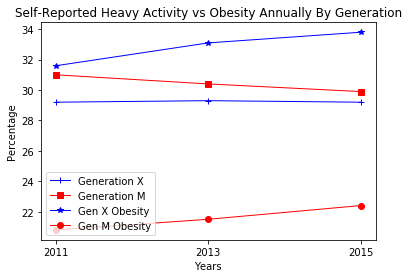

In [62]:
#ACTIVITY LINE GRAPHS- Heavy Activity -Dar
# Set x axis to numerical value for month
x_axis = "2011","2013","2015"



# Avearge GenX not exercising each year
activityGenX = [29.2, 29.3, 29.2]
# Avearge GenM not exercising each year
activityGenM = [31, 30.4, 29.9]
# Avearge GenX obese each year
obesityGenX = [31.6, 33.1, 33.8]
# Avearge GenM obese each year
obesityGenM = [20.8, 21.5, 22.4]

# Create a handle for each plot
genX, = plt.plot(x_axis, activityGenX, marker="+",color="blue", linewidth=1, label="Generation X")
genM, = plt.plot(x_axis, activityGenM, marker="s", color="Red", linewidth=1, label="Generation M")
genXo, = plt.plot(x_axis, obesityGenX, marker="*",color="blue", linewidth=1, label="Gen X Obesity")
genMo, = plt.plot(x_axis, obesityGenM, marker="o", color="Red", linewidth=1, label="Gen M Obesity")

# Set our legend to where the chart thinks is best
plt.legend(handles=[genX, genM, genXo, genMo], loc="best")

# Create labels for the X and Y axis
plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title('Self-Reported Heavy Activity vs Obesity Annually By Generation')


# Save and display the chart
# Save and display the chart
plt.savefig("Resources/HeavyActivityLineChart.png")
plt.show()

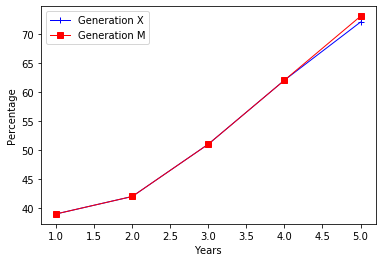

In [63]:
#NUTRITION LINE GRAPHS -Dar
# Set x axis to numerical value for month
x_axis = np.arange(1,6,1)
x_axis

# Avearge GenX not exercising each year
nutritionGenX = [39, 42, 51, 62, 72]
# Avearge GenM not exercising each year
nutritionGenM = [39, 42, 51, 62, 73]

# Create a handle for each plot
genX, = plt.plot(x_axis, nutritionGenX, marker="+",color="blue", linewidth=1, label="Generation X")
genM, = plt.plot(x_axis, nutritionGenM, marker="s", color="Red", linewidth=1, label="Generation M")

# Set our legend to where the chart thinks is best
plt.legend(handles=[genX, genM], loc="best")

# Create labels for the X and Y axis
plt.xlabel("Years")
plt.ylabel("Percentage")

# Save and display the chart

plt.show()

#NUTRITION LINE GRAPHS WILL NOT WORK AS THERE IS ONLY ONE YEAR (2017) REPRESENTED##